# La forma normale di Chomsky

## Regole/simboli produttivi e raggiungibili (Sez. 2.9.5.1-2)

In [1]:
from liblet import Grammar, closure, union_of

In [2]:
def find_productive(G):
    @closure
    def find(prod):
        return prod | {A for A, β in G.P if set(β) <= prod}
    return set(find(G.T))

def find_reachable(G):
    @closure
    def find(reach, G):
        return reach | union_of(set(β) for A, β in G.P if A in reach)
    return find({G.S}, G)   

def remove_unproductive_unreachable(G):
    Gp = G.restrict_to(find_productive(G))
    return Gp.restrict_to(find_reachable(Gp))

In [3]:
# fig 2.27, pag. 49

G = Grammar.from_string("""
S -> A B | D E
A -> a
B -> b C
C -> c
D -> d F 
E -> e 
F -> f D
""")
G

Grammar(N={A, B, C, D, E, F, S}, T={a, b, c, d, e, f}, P=(S -> A B, S -> D E, A -> a, B -> b C, C -> c, D -> d F, E -> e, F -> f D), S=S)

In [4]:
productive = find_productive(G)
productive

{'A', 'B', 'C', 'E', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

In [5]:
reachable = find_reachable(G)
reachable

{'A', 'B', 'C', 'D', 'E', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

In [6]:
remove_unproductive_unreachable(G)

Grammar(N={A, B, C, S}, T={a, b, c}, P=(S -> A B, A -> a, B -> b C, C -> c), S=S)

In [7]:
Gp = G.restrict_to(find_productive(G))
Gp.restrict_to(find_reachable(G))

Grammar(N={A, B, C, E, S}, T={a, b, c, d, e, f}, P=(S -> A B, A -> a, B -> b C, C -> c, E -> e), S=S)

## Eliminazione ε-regole (Sez. 4.2.3.1)

In [8]:
from liblet import Production, prods2table

@closure
def replace_in_rhs(G, A):
    Ap = A + '’'
    prods = set()
    for B, β in G.P:
        if A in β:
            pos = β.index(A)
            rhs = β[:pos] + β[pos + 1:]
            if len(rhs) == 0: rhs = ('ε', )
            prods.add(Production(B, rhs))
            prods.add(Production(B, β[:pos] + (Ap, ) + β[pos + 1:]))
        else:
            prods.add(Production(B, β))    
    return Grammar(G.N | {Ap}, G.T, prods, G.S)

@closure
def inline_ε_rules(G_seen):
    G, seen = G_seen
    for A in G.N - seen:
        if ('ε', ) in G.alternatives(A):
            return replace_in_rhs(G, A), seen | {A}
    return G, seen

def eliminate_ε_rules(G):
    Gp, _ = inline_ε_rules((G, set()))
    prods = set(Gp.P)
    for Ap in Gp.N - G.N:
        A = Ap[:-1]
        for α in set(Gp.alternatives(A)) - {('ε', )}:
            prods.add(Production(Ap, α))
    return Grammar(Gp.N, Gp.T, prods, Gp.S)

In [9]:
# fig. 4.10, pag. 120

G = Grammar.from_string("""
S -> L a M
L -> L M 
L -> ε
M -> M M
M -> ε
""")
G


Grammar(N={L, M, S}, T={a}, P=(S -> L a M, L -> L M, L -> ε, M -> M M, M -> ε), S=S)

In [10]:
Gp = eliminate_ε_rules(G)
prods2table(Gp)

In [11]:
remove_unproductive_unreachable(Gp)

Grammar(N={S}, T={a}, P=(S -> a,), S=S)

In [12]:
# fig. 4.6, pag. 112

G = Grammar.from_string("""
Number -> Integer | Real
Integer -> Digit | Integer Digit
Real -> Integer Fraction Scale
Fraction -> . Integer
Scale -> e Sign Integer | Empty
Digit -> 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
Sign -> + | -
Empty -> ε
""")

In [13]:
# fig. 4.12, pag. 120 (a meno di Empty’)

Gp = eliminate_ε_rules(G)
prods2table(Gp)

## Eliminazione regole unitarie (Sez. 4.2.3.2)

In [14]:
@closure
def eliminate_unit_rules(G_seen):
    G, seen = G_seen
    for P in set(filter(Production.such_that(rhs_len = 1), G.P)) - seen:
        A, (B, ) = P
        if B in G.N:            
            prods = (set(G.P) | {Production(A, α) for α in G.alternatives(B)}) - {P}
            return Grammar(G.N, G.T, prods, G.S), seen | {P}
    return G, seen

In [15]:
# fig. 4.13, pag. 121

Gp, seen = eliminate_unit_rules((Gp, set()))
prods2table(Gp)

## Riduzione in forma normale

### Pulizia (Sez. 4.2.3.3)

In [16]:
# fig. 4.14, pag. 122

Gp_clean = remove_unproductive_unreachable(Gp)
prods2table(Gp_clean)

### Caso $A\to a$

In [17]:
def transform_nonsolitary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 1 and set(α) & G.T:
            rhs = []
            for x in α:
                if x in G.T:
                    N = 'N{}'.format(x)
                    prods.add(Production(N, (x, )))
                    rhs.append(N)
                else:
                    rhs.append(x)
            prods.add(Production(A, rhs))
        else:            
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [18]:
G0 = transform_nonsolitary(Gp_clean)
prods2table(G0)

### Caso $A\to X_1 X_2\ldots X_n$

In [19]:
def make_binary(G):
    prods = set()
    for A, α in G.P:
        if len(α) > 2:
            Ai = '{}{}'.format(A, 1)
            prods.add(Production(Ai, α[:2]))
            for i, Xi in enumerate(α[2:-1], 2):
                prods.add(Production('{}{}'.format(A, i), (Ai, Xi)))
                Ai = '{}{}'.format(A, i)
            prods.add(Production(A, (Ai, α[-1])))
        else:
            prods.add(Production(A, α))
    return Grammar(G.N | {A for A, α in prods}, G.T, prods, G.S)

In [20]:
# fig. 4.15, pag. 123 (rinominando alcuni non terminali)

Gcnf = make_binary(G0)
prods2table(Gcnf)

# Costruzione dell'albero di parsing

## Ripetiamo il popolamento della tabella (riconoscimento)

In [21]:
def cyk(G, INPUT):
    def fill(R, i, l):
        res = set()
        if l == 1:
            for (A, (a, *α)) in G.P: 
                if not α and a == INPUT[i - 1]:
                    res.add(A)
        else:
            for k in range(1, l):
                for A, α in G.P:
                    if len(α) != 2: continue
                    B, C = α
                    if B in R[(i, k)] and C in R[(i + k, l - k)]:
                        res.add(A)
        return res
    R = {}
    for l in range(1, len(INPUT) + 1):
        for i in range(1, len(INPUT) - l + 2): 
            R[(i, l)] = fill(R, i, l)
    return R

In [22]:
# fig. 4.16, pag. 123

from liblet import cyk2table

INPUT = '32.5e+1'
R = cyk(Gcnf, INPUT)
cyk2table(R)

## L'albero di parsing (barando)

In [23]:
def get_parse_tree(G, R, INPUT):
    def tree(X, i, l):
        if l == 1: return [X, [INPUT[i-1]]]
        for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
            for k in range(1, l):
                if B in R[(i, k)] and C in R[(i + k, l - k)]:
                    return [A, tree(B, i, k), tree(C, i + k, l - k)]
    return tree(G.S, 1, len(INPUT))

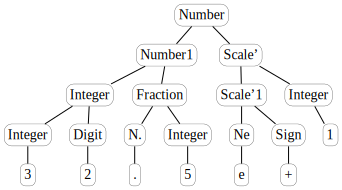

In [24]:
from liblet import Tree

Tree.from_lol(get_parse_tree(Gcnf, R, INPUT))

## Una derivazione leftmost

In [25]:
from liblet import show_calls

def get_leftmost_prods(G, R, INPUT):
    @show_calls(True)
    def prods(X, i, l):
        if l == 1:
            return [G.P.index(Production(X, (INPUT[i - 1],)))]
        for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
            for k in range(1, l):
                if B in R[(i, k)] and C in R[(i + k, l - k)]:
                    return [G.P.index(Production(A, (B, C)))] + prods(B, i, k) + prods(C, i + k, l - k)
    return prods(G.S, 1, len(INPUT))            

In [26]:
leftmost_prods = get_leftmost_prods(Gcnf, R, INPUT)
leftmost_prods

┌prods('Number', 1, 7)
│┌prods('Number1', 1, 4)
││┌prods('Integer', 1, 2)
│││┌prods('Integer', 1, 1)
│││└─ [1]
│││┌prods('Digit', 2, 1)
│││└─ [7]
││└─ [11, 1, 7]
││┌prods('Fraction', 3, 2)
│││┌prods('N.', 3, 1)
│││└─ [9]
│││┌prods('Integer', 4, 1)
│││└─ [40]
││└─ [28, 9, 40]
│└─ [26, 11, 1, 7, 28, 9, 40]
│┌prods('Scale’', 5, 3)
││┌prods('Scale’1', 5, 2)
│││┌prods('Ne', 5, 1)
│││└─ [36]
│││┌prods('Sign', 6, 1)
│││└─ [31]
││└─ [6, 36, 31]
││┌prods('Integer', 7, 1)
││└─ [21]
│└─ [32, 6, 36, 31, 21]
└─ [10, 26, 11, 1, 7, 28, 9, 40, 32, 6, 36, 31, 21]


[10, 26, 11, 1, 7, 28, 9, 40, 32, 6, 36, 31, 21]

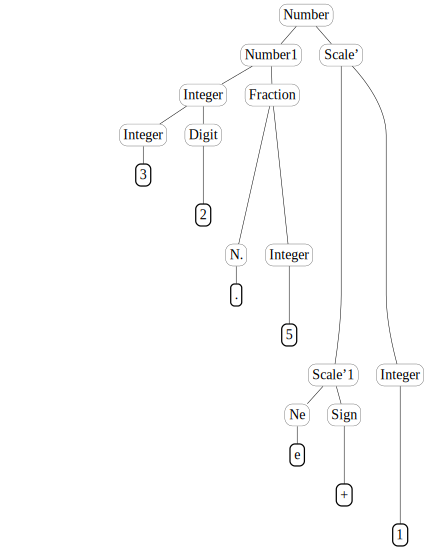

In [27]:
from liblet import Derivation, ProductionGraph

d = Derivation(Gcnf)
for prod in leftmost_prods: d = d.leftmost(prod)
    
ProductionGraph(d)    

# E la grammatica originale? (Sez. 4.2.6)

In [28]:
Gcnfp = transform_nonsolitary(make_binary(Gp))
prods2table(Gcnfp)

In [29]:
# fig. 4.17, pag. 126

from liblet import cyk2table

INPUT = '32.5e+1'
Rorig = cyk(Gcnfp, INPUT)

# aggiungo l'ultima riga, con i nullable di Rε

Rε = {A for A in Gcnfp.N if ('ε', ) in Gcnfp.alternatives(A)}
for i in range(len(INPUT) + 2): Rorig[(i, 0)] = Rε

cyk2table(Rorig)

# Homework

* Scrivere una versione di `get_leftmost_prods` che restituisca, invece delle produzioni
  della derivazione *leftmost* quelle della derivazione *rightmost* [facile];
  
* Scrivere una versione di `get_parse_tree` che restituisca tutti i possibli alberi di parsing,
  non soltanto uno come quella presentata qui [difficile];
  
* Implementate l'algoritmo descritto nella Sez. 4.2.6 per produrre l'albero di parsing nella
  grammatica originale a partire dalla tabella ottenuta nella sezione precedente [media difficoltà].